In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

PyTorch version: 2.5.1
CUDA available: True
CUDA version: 11.8


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Subset 
import matplotlib.pyplot as plt
import torchvision

In [3]:
from torch.utils.data import Dataset

class RemappedDataset(Dataset):
    def __init__(self, base_dataset, allowed_class_ids, allowed_class_names):
        self.base_dataset = base_dataset
        self.allowed_class_ids = allowed_class_ids
        self.label_map = {orig: new for new, orig in enumerate(sorted(allowed_class_ids))}
        self.new_classes = allowed_class_names

        # Keep only samples with allowed labels
        self.indices = [i for i, (_, label) in enumerate(base_dataset.samples) if label in allowed_class_ids]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        img, label = self.base_dataset[real_idx]
        return img, self.label_map[label]  # remap label here

    def classes(self):
        return self.new_classes




_imagenet_pca = {
    'eigval': torch.Tensor([0.2175, 0.0188, 0.0045]),
    'eigvec': torch.Tensor([
        [-0.5675, 0.7192, 0.4009],
        [-0.5808, -0.0045, -0.8140],
        [-0.5836, -0.6948, 0.4203],
    ])
}

class Lighting(object):
    """Lighting noise(AlexNet - style PCA - based noise)"""

    def __init__(self, alphastd, eigval=_imagenet_pca['eigval'],
                 eigvec=_imagenet_pca['eigvec']):
        self.alphastd = alphastd
        self.eigval = eigval
        self.eigvec = eigvec

    def __call__(self, img):
        if self.alphastd == 0:
            return img

        alpha = img.new().resize_(3).normal_(0, self.alphastd)
        rgb = self.eigvec.type_as(img).clone() \
            .mul(alpha.view(1, 3).expand(3, 3)) \
            .mul(self.eigval.view(1, 3).expand(3, 3)) \
            .sum(1).squeeze()

        return img.add(rgb.view(3, 1, 1).expand_as(img))

In [4]:

# -------------------------
# Step 1: Define config
# -------------------------

allowed_classes = ['cement', 'dry_leaf', 'grass', 'rocks', 'sand', 'soil', 'wood_chips']
train_dir = 'dataset/train'
test_dir = 'dataset/test'
batch_size = 512


# -------------------------
# Step 2: Define transform
# -------------------------

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
transform_train = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4),
            transforms.ToTensor(),
            Lighting(0.1),
            normalize,
        ])
transform_test = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])
# -------------------------
# Step 3: Load full datasets
# -------------------------

full_train_dataset = datasets.ImageFolder(train_dir, transform = transform_train)
full_test_dataset = datasets.ImageFolder(test_dir, transform = transform_test)

print(full_train_dataset.classes)

# -------------------------
# Step 4: Get allowed indices
# -------------------------

# Get label indices for the allowed class names
allowed_train_class_ids = [full_train_dataset.class_to_idx[cls] for cls in allowed_classes]
allowed_test_class_ids = [full_test_dataset.class_to_idx[cls] for cls in allowed_classes]

# Remapped dataset
train_dataset = RemappedDataset(full_train_dataset, allowed_train_class_ids, allowed_classes)
test_dataset = RemappedDataset(full_test_dataset, allowed_test_class_ids, allowed_classes)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


# # Filter samples that match those class IDs
# train_indices = [i for i, (_, label) in enumerate(full_train_dataset.samples) if label in allowed_train_class_ids]
# test_indices = [i for i, (_, label) in enumerate(full_test_dataset.samples) if label in allowed_test_class_ids]

# # -------------------------
# # Step 5: Create Subsets
# # -------------------------

# train_dataset = Subset(full_train_dataset, train_indices)
# test_dataset = Subset(full_test_dataset, test_indices)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



['cement', 'dry_leaf', 'grass', 'rocks', 'sand', 'soil', 'wood_chips']


In [5]:
# -------------------------
# Step 6: Unnormalization helper
# -------------------------

def unnormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    return img_tensor * std + mean

# -------------------------
# Step 7: Visualize a batch
# -------------------------

def show_batch(images, labels, class_names):
    unnorm_images = unnormalize(images)
    grid = torchvision.utils.make_grid(unnorm_images, nrow=4)
    plt.figure(figsize=(10, 6))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title([class_names[i] for i in labels])
    plt.axis('off')
    plt.show()

# Example usage: visualize train batch
train_images, train_labels = next(iter(train_loader))
show_batch(train_images, train_labels, train_dataset.new_classes)

# Example usage: visualize test batch
test_images, test_labels = next(iter(test_loader))
show_batch(test_images, test_labels, test_dataset.new_classes)


KeyboardInterrupt: 

In [6]:
from torchvision import models
import torch.nn as nn
from torchvision.models import MobileNet_V2_Weights

# Load pretrained MobileNetV2
model = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)

# Freeze the backbone (feature extractor)
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier for your 15 classes
num_classes = len(allowed_classes)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=model.last_channel, out_features=64, bias=True),
    nn.BatchNorm1d(64),
    nn.ReLU(),

   
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=64, out_features=num_classes, bias=True),

)


# checkpoint_path = 'best_model.pth'
# model.load_state_dict(torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_available() else 'cpu'))

# Show model structure
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

## Training Setup

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 35
checkpoint_path = "best_model.pth"

# Tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    
    loop = tqdm(train_loader, total=len(train_loader))
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_running_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss = val_running_loss / len(test_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}")

    torch.save(model.state_dict(), 'model_' + str(epoch + 1) + '.pth')
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✅ Saved best model with val loss {val_loss:.4f}")



Epoch 1/35


Epoch 1: 100%|██████████| 69/69 [05:25<00:00,  4.72s/it, loss=0.412]


Train Loss: 0.7002, Train Acc: 0.8157
Val Loss:   0.5339, Val Acc:   0.8419
✅ Saved best model with val loss 0.5339

Epoch 2/35


Epoch 2: 100%|██████████| 69/69 [02:23<00:00,  2.09s/it, loss=0.295]


Train Loss: 0.3490, Train Acc: 0.8968
Val Loss:   0.4552, Val Acc:   0.8494
✅ Saved best model with val loss 0.4552

Epoch 3/35


Epoch 3: 100%|██████████| 69/69 [02:17<00:00,  2.00s/it, loss=0.253]


Train Loss: 0.2757, Train Acc: 0.9119
Val Loss:   0.4030, Val Acc:   0.8606
✅ Saved best model with val loss 0.4030

Epoch 4/35


Epoch 4: 100%|██████████| 69/69 [02:18<00:00,  2.01s/it, loss=0.248]


Train Loss: 0.2551, Train Acc: 0.9153
Val Loss:   0.4181, Val Acc:   0.8456

Epoch 5/35


Epoch 5: 100%|██████████| 69/69 [02:05<00:00,  1.82s/it, loss=0.19] 


Train Loss: 0.2357, Train Acc: 0.9193
Val Loss:   0.4586, Val Acc:   0.8472

Epoch 6/35


Epoch 6: 100%|██████████| 69/69 [02:17<00:00,  2.00s/it, loss=0.258]


Train Loss: 0.2283, Train Acc: 0.9218
Val Loss:   0.3955, Val Acc:   0.8622
✅ Saved best model with val loss 0.3955

Epoch 7/35


Epoch 7: 100%|██████████| 69/69 [02:22<00:00,  2.06s/it, loss=0.26] 


Train Loss: 0.2199, Train Acc: 0.9215
Val Loss:   0.4597, Val Acc:   0.8456

Epoch 8/35


Epoch 8: 100%|██████████| 69/69 [05:06<00:00,  4.45s/it, loss=0.245]


Train Loss: 0.2151, Train Acc: 0.9252
Val Loss:   0.3639, Val Acc:   0.8579
✅ Saved best model with val loss 0.3639

Epoch 9/35


Epoch 9: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it, loss=0.184]


Train Loss: 0.2041, Train Acc: 0.9281
Val Loss:   0.4099, Val Acc:   0.8446

Epoch 10/35


Epoch 10: 100%|██████████| 69/69 [02:23<00:00,  2.09s/it, loss=0.308]


Train Loss: 0.2027, Train Acc: 0.9284
Val Loss:   0.4187, Val Acc:   0.8616

Epoch 11/35


Epoch 11: 100%|██████████| 69/69 [02:36<00:00,  2.26s/it, loss=0.196]


Train Loss: 0.1961, Train Acc: 0.9294
Val Loss:   0.4778, Val Acc:   0.8526

Epoch 12/35


Epoch 12: 100%|██████████| 69/69 [02:38<00:00,  2.29s/it, loss=0.244]


Train Loss: 0.1964, Train Acc: 0.9302
Val Loss:   0.5106, Val Acc:   0.8579

Epoch 13/35


Epoch 13: 100%|██████████| 69/69 [02:36<00:00,  2.27s/it, loss=0.252]


Train Loss: 0.1935, Train Acc: 0.9307
Val Loss:   0.4118, Val Acc:   0.8723

Epoch 14/35


Epoch 14: 100%|██████████| 69/69 [02:15<00:00,  1.96s/it, loss=0.275]


Train Loss: 0.1848, Train Acc: 0.9353
Val Loss:   0.4460, Val Acc:   0.8584

Epoch 15/35


Epoch 15: 100%|██████████| 69/69 [02:20<00:00,  2.04s/it, loss=0.197]


Train Loss: 0.1853, Train Acc: 0.9337
Val Loss:   0.4459, Val Acc:   0.8595

Epoch 16/35


Epoch 16: 100%|██████████| 69/69 [02:27<00:00,  2.13s/it, loss=0.158]


Train Loss: 0.1864, Train Acc: 0.9326
Val Loss:   0.4428, Val Acc:   0.8595

Epoch 17/35


Epoch 17: 100%|██████████| 69/69 [02:12<00:00,  1.92s/it, loss=0.145]


Train Loss: 0.1779, Train Acc: 0.9353
Val Loss:   0.4940, Val Acc:   0.8504

Epoch 18/35


Epoch 18: 100%|██████████| 69/69 [02:27<00:00,  2.14s/it, loss=0.186]


Train Loss: 0.1808, Train Acc: 0.9350
Val Loss:   0.4282, Val Acc:   0.8616

Epoch 19/35


Epoch 19: 100%|██████████| 69/69 [02:32<00:00,  2.21s/it, loss=0.299]


Train Loss: 0.1785, Train Acc: 0.9360
Val Loss:   0.4029, Val Acc:   0.8622

Epoch 20/35


Epoch 20: 100%|██████████| 69/69 [02:35<00:00,  2.25s/it, loss=0.192]


Train Loss: 0.1755, Train Acc: 0.9369
Val Loss:   0.4784, Val Acc:   0.8440

Epoch 21/35


Epoch 21: 100%|██████████| 69/69 [02:10<00:00,  1.89s/it, loss=0.178] 


Train Loss: 0.1752, Train Acc: 0.9364
Val Loss:   0.4977, Val Acc:   0.8526

Epoch 22/35


Epoch 22: 100%|██████████| 69/69 [02:07<00:00,  1.85s/it, loss=0.249]


Train Loss: 0.1762, Train Acc: 0.9374
Val Loss:   0.4072, Val Acc:   0.8622

Epoch 23/35


Epoch 23: 100%|██████████| 69/69 [02:11<00:00,  1.91s/it, loss=0.208]


Train Loss: 0.1720, Train Acc: 0.9390
Val Loss:   0.4352, Val Acc:   0.8632

Epoch 24/35


Epoch 24: 100%|██████████| 69/69 [02:15<00:00,  1.97s/it, loss=0.236]


Train Loss: 0.1697, Train Acc: 0.9395
Val Loss:   0.5167, Val Acc:   0.8590

Epoch 25/35


Epoch 25: 100%|██████████| 69/69 [02:03<00:00,  1.78s/it, loss=0.233]


Train Loss: 0.1635, Train Acc: 0.9413
Val Loss:   0.4738, Val Acc:   0.8670

Epoch 26/35


Epoch 26: 100%|██████████| 69/69 [02:00<00:00,  1.74s/it, loss=0.212]


Train Loss: 0.1633, Train Acc: 0.9417
Val Loss:   0.4903, Val Acc:   0.8590

Epoch 27/35


Epoch 27: 100%|██████████| 69/69 [02:08<00:00,  1.86s/it, loss=0.111]


Train Loss: 0.1634, Train Acc: 0.9409
Val Loss:   0.4721, Val Acc:   0.8558

Epoch 28/35


Epoch 28: 100%|██████████| 69/69 [02:08<00:00,  1.86s/it, loss=0.153]


Train Loss: 0.1642, Train Acc: 0.9410
Val Loss:   0.4449, Val Acc:   0.8616

Epoch 29/35


Epoch 29:   9%|▊         | 6/69 [00:13<02:22,  2.27s/it, loss=0.14] 


KeyboardInterrupt: 

In [8]:
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Plots training and validation loss and accuracy curves.

    Args:
        train_losses (list of float): Training loss values per epoch.
        val_losses (list of float): Validation loss values per epoch.
        train_accuracies (list of float): Training accuracy values per epoch.
        val_accuracies (list of float): Validation accuracy values per epoch.
    """
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Val Loss', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_accuracies, label='Val Accuracy', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


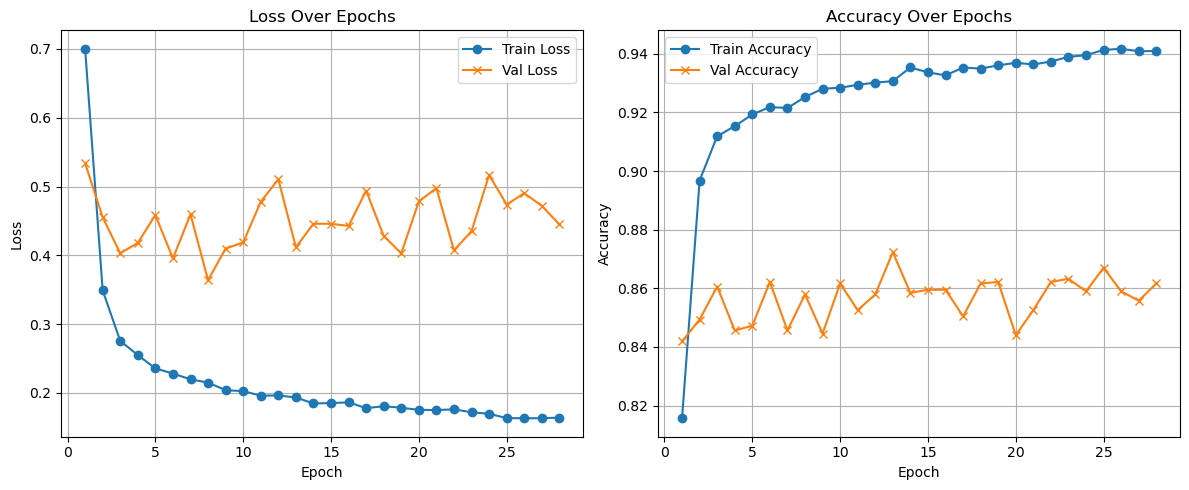

In [9]:
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

In [10]:
checkpoint_path = 'model_25.pth'
model.load_state_dict(torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_available() else 'cpu'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

C:\Users\AsusIran\AppData\Local\Temp\ipykernel_19584\3327482195.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_loc

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Set model to evaluation mode
model.eval()

# Collect predictions and ground truths
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=allowed_classes)

plt.figure(figsize=(10, 10))
disp.plot(xticks_rotation=45, cmap='Blues', values_format='d')
plt.title("Confusion Matrix on Test Set")
plt.show()

KeyboardInterrupt: 